## Keras: introduction

keras は deep learning を簡単に記述することができるフレームワークです。
高レベル API を提供するための wrapper ライブラリというような位置づけで、バックエンド（数値計算部分）を tensorflow にしたり theano にしたりできます。
さらに最近では tensorflow に取り込まれ、`tf.keras` という形で利用することもできるようになっています。

`tf.keras` を使うことで、 tensorflow のエコシステムに乗っかりつつ、簡単な記述でニューラルネットワークを学習させることができます。
というわけで今回は `tf.keras` を使ってみます。

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

###  deep learning 界の Hello, world

deep learning の世界では、Hello, world として MNIST がよく使われます。
MNIST は 0~9 まで手書き文字を認識するというタスクで、データサイズも小さく問題も簡単です。

有名なフレームワークは大体 MNIST データセットをダウンロードする utility 関数を提供しています。keras にもあるのでそれを使ってデータをダウンロードし、何枚かデータを見てみます。

type of images:  <class 'numpy.ndarray'>
shape of images:  (60000, 28, 28)
type of labels:  <class 'numpy.ndarray'>
shape of labels:  (60000,)
label of images[0] is  5


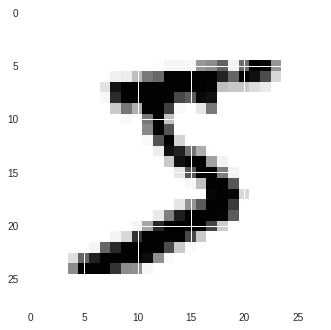

In [39]:
(images, labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print("type of images: ", type(images))
print("shape of images: ", images.shape)
print("type of labels: ", type(labels))
print("shape of labels: ", labels.shape)


print("label of images[0] is ", labels[0])
plt.imshow(images[0])

全部で 60000 枚の画像と正解ラベルが与えられています。
それぞれの画像は、サイズ 28x28 、grayscale になっていることがわかります。
そして正解ラベルは 0~9 までの数字が入っていることもわかります。

通常画像データは RGB など複数のチャネルを持っているので、WxHxC の 3 次元行列として扱います。
今回のデータは 1 チャネルしかないのですが、形式を揃えるために 28x28x1 に reshape しておきます。

In [0]:
images = np.expand_dims(images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

labels = tf.keras.utils.to_categorical(labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

画像を入力に、0~9 までの文字である確率をそれぞれ返すようなモデルを作ることを目標にします。

例えば↑の画像を入力すると、`0 である確率: 0.01, 1 である確率: 0.01, 2 である確率: 0.04, ..., 5 である確率: 0.88, ..., 9 である確率: 0.02` のような出力が得られるというイメージです。  
なので、この場合は `28x28x1` の行列から `10` 要素のベクトルを得られるようなモデルを書くことが必要になります。

## Keras のモデル例

いきなりですが、これらの画像からラベルを当てるようなモデル例を keras で記述してみます。

In [41]:
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation


def create_model():
    input = Input(shape=(28, 28, 1))
    x = Conv2D(32, kernel_size=3)(input)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(10)(x)
    output = Activation('softmax')(x)

    return tf.keras.Model(input, output)

model = create_model()
model.summary()
model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_48 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_49 (Activation)   (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 9216)              0         
__________

これが keras の典型的なモデルの定義方法です。

一行ずつ実行しながらコメントつけてみます。
行列の shape に注目してみるとどんなことをしているのかなんとなく把握できるかもしれません。

フレームワークを使った deep learning は、行列の shape をあわせる作業です。
入力行列の shape が、層を経るごとにどう変化していくかを把握できると、自分で NN を組み立てるヒントになります。

In [42]:
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation

# まず入力となる（計算グラフ上の）変数を定義します。後でこの変数に実際の画像データを入力し、計算グラフを評価することになります。
input = Input(shape=(28, 28, 1))
input # shape は (?, 28, 28, 1) になります。? はバッチサイズというもので、計算実行時に勝手に埋められるので今は無視して構いません。（学習時には複数枚同時に学習します。一度に見る枚数をバッチサイズといいます。たとえば 32 枚同時に学習する場合は、(32, 28, 28, 1) になります。）

<tf.Tensor 'input_14:0' shape=(?, 28, 28, 1) dtype=float32>

In [43]:
# 二次元の convolution を行います。(今回は詳細は省きますが) f(x) = w * x + b のちょっと特殊な形だと考えてください。
x = Conv2D(32, kernel_size=3, padding='same')(input)
x 

<tf.Tensor 'conv2d_26/BiasAdd:0' shape=(?, 28, 28, 32) dtype=float32>

In [44]:
# convolution の結果を活性化関数に入れます。活性化関数として今回は relu というものを使いました。（有名な活性化関数で、最近の NN では relu を使うのが主流だと思います。）
x = Activation('relu')(x)
x # 活性化関数は値だけを変化させるので shape は変わりません。

<tf.Tensor 'activation_52/Relu:0' shape=(?, 28, 28, 32) dtype=float32>

In [45]:
# ↑と同じものを繰り返します。
x = Conv2D(64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x

<tf.Tensor 'activation_53/Relu:0' shape=(?, 28, 28, 64) dtype=float32>

In [46]:
# MaxPooling はちょっと特殊な補助層のようなものです。2x2 のマスごとに最大値をとる操作をします。
x = MaxPooling2D(pool_size=2)(x)
x # 2x2 → 1x1 になるので、縦横ともに半分になります。

<tf.Tensor 'max_pooling2d_13/MaxPool:0' shape=(?, 14, 14, 64) dtype=float32>

In [47]:
# 行列を平らにします。14x14x64 の行列を 12,544 の行列（ベクトル）に変換するだけです。値は変わりません。
x = Flatten()(x)
x 

<tf.Tensor 'flatten_13/Reshape:0' shape=(?, 12544) dtype=float32>

In [48]:
# Dense は w * x + b そのものを行う層です。w は 12544x128 の行列、x は↑なので 12544 の行列です。つまり w * x の shape は 128 になります。
x = Dense(128)(x)
x = Activation('relu')(x)
x

<tf.Tensor 'activation_54/Relu:0' shape=(?, 128) dtype=float32>

In [49]:
# ↑と同じく w * x + b を行います。ここでの w は 128x10 の行列になります。
x = Dense(10)(x)
output = Activation('softmax')(x)
output # 今回の問題は 10 クラス分類なので、10 次元のベクトルを返すようにします。

<tf.Tensor 'activation_55/Softmax:0' shape=(?, 10) dtype=float32>

In [50]:

model = tf.keras.Model(input, output)
model

## 学習

学習は以下のように行います

In [51]:
model = create_model()
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=images, y=labels, batch_size=64, epochs=100, validation_data=(test_images, test_labels))
# loss は損失関数の値、acc は精度（正解率）

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 11s 175us/step - loss: 11.8661 - acc: 0.2540 - val_loss: 0.2185 - val_acc: 0.9378
Epoch 2/100
60000/60000 [==============================] - 10s 167us/step - loss: 0.0976 - acc: 0.9706 - val_loss: 0.0686 - val_acc: 0.9792
Epoch 3/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.0397 - acc: 0.9879 - val_loss: 0.0425 - val_acc: 0.9864
Epoch 4/100
60000/60000 [==============================] - 10s 168us/step - loss: 0.0228 - acc: 0.9932 - val_loss: 0.0406 - val_acc: 0.9878
Epoch 5/100
60000/60000 [==============================] - 10s 165us/step - loss: 0.0143 - acc: 0.9958 - val_loss: 0.0466 - val_acc: 0.9863
Epoch 6/100
60000/60000 [==============================] - 10s 167us/step - loss: 0.0085 - acc: 0.9976 - val_loss: 0.0419 - val_acc: 0.9887
Epoch 7/100
60000/60000 [==============================] - 10s 165us/step - loss: 0.0044 - acc: 0.9989 - val_

acc（精度）が 1.000 になっています。
これは、学習データすべてに対して完璧に正解を当てられているということです。

一方で、val_acc（validation accuracy, 学習に使っていないデータにおける精度）は 0.99 程度が限界になっています。
これが過学習という問題で、これを起こさないようにするのが deep learning の難しさの一つです。
（データをもっとたくさん与えれば過学習問題は軽減できます。）


また、↑にあげたモデル以外にもいろいろなモデル設計を考えることができます。
以下にいくつかの例をあげます。

In [54]:
# ものすごく simple なモデル。精度は全然あがらない。
def create_simple_model():
  input = Input(shape=(28, 28, 1))
  x = Flatten()(input)
  x = Dense(10)(x)
  output = Activation('softmax')(x)
  return tf.keras.Model(input, output)

model = create_simple_model()
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=images, y=labels, batch_size=64, epochs=10, validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 62us/step - loss: 11.5588 - acc: 0.2824 - val_loss: 11.2469 - val_acc: 0.3019
Epoch 2/10
60000/60000 [==============================] - 4s 63us/step - loss: 9.9649 - acc: 0.3814 - val_loss: 9.8542 - val_acc: 0.3884
Epoch 3/10
60000/60000 [==============================] - 4s 62us/step - loss: 9.7936 - acc: 0.3921 - val_loss: 9.6658 - val_acc: 0.4000
Epoch 4/10
60000/60000 [==============================] - 4s 61us/step - loss: 9.7635 - acc: 0.3940 - val_loss: 9.8296 - val_acc: 0.3899
Epoch 5/10
60000/60000 [==============================] - 4s 62us/step - loss: 9.8152 - acc: 0.3909 - val_loss: 9.6607 - val_acc: 0.4006
Epoch 6/10
60000/60000 [==============================] - 4s 60us/step - loss: 9.7976 - acc: 0.3920 - val_loss: 9.9709 - val_acc: 0.3811
Epoch 7/10
60000/60000 [==============================] - 3s 57us/step - loss: 9.7531 - acc: 0.3948 - val_loss: 9.6584 - val_a

In [58]:
# ちょっとだけ良いモデル。 val_acc が高くなっている。
def create_better_model():
    from tensorflow.python.keras.layers import BatchNormalization, Dropout
    input = Input(shape=(28, 28, 1))
    x = Conv2D(32, kernel_size=3)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(10)(x)
    output = Activation('softmax')(x)

    return tf.keras.Model(input, output)

model = create_better_model()
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=images, y=labels, batch_size=64, epochs=100, validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 14s 238us/step - loss: 0.2576 - acc: 0.9198 - val_loss: 0.0758 - val_acc: 0.9767
Epoch 2/100
60000/60000 [==============================] - 13s 223us/step - loss: 0.1046 - acc: 0.9688 - val_loss: 0.0556 - val_acc: 0.9812
Epoch 3/100
60000/60000 [==============================] - 13s 223us/step - loss: 0.0785 - acc: 0.9761 - val_loss: 0.0473 - val_acc: 0.9846
Epoch 4/100
60000/60000 [==============================] - 13s 223us/step - loss: 0.0651 - acc: 0.9805 - val_loss: 0.0431 - val_acc: 0.9861
Epoch 5/100
60000/60000 [==============================] - 13s 220us/step - loss: 0.0567 - acc: 0.9824 - val_loss: 0.0352 - val_acc: 0.9889
Epoch 6/100
60000/60000 [==============================] - 13s 222us/step - loss: 0.0497 - acc: 0.9842 - val_loss: 0.0345 - val_acc: 0.9883
Epoch 7/100
60000/60000 [==============================] - 13s 220us/step - loss: 0.0452 - acc: 0.9860 - val_l